<a href="https://colab.research.google.com/github/arminnorouzi/machine_learning_course_UofA_MECE610/blob/main/L04_Deep_Learning_with_TensorFlow/L04b_Project_Covid19_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# L04b Project: Covid19 classifier based on X-rays lung image
   - Developed by **Armin Norouzi**
   - Compatible with Google Colaboratory- Tensorflow 2.8.2

   
   - **Objective:** Build a deep learning model to predict that patients who had either pneumonia, Covid-19, or no illness based on X-ray lung scans.




In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy

## Geting data and being familiar with data

### Get the data

In [2]:
import zipfile

# Download zip file of pizza_steak images
!wget https://gitlab.com/arminny/ml_course_datasets/-/raw/main/Covid19-dataset.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("Covid19-dataset.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-09-21 16:28:24--  https://gitlab.com/arminny/ml_course_datasets/-/raw/main/Covid19-dataset.zip
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21847859 (21M) [application/octet-stream]
Saving to: ‘Covid19-dataset.zip’

Covid19-dataset.zip 100%[===================>]  20.83M  63.9MB/s    in 0.3s    

2022-09-21 16:28:25 (63.9 MB/s) - ‘Covid19-dataset.zip’ saved [21847859/21847859]



In [3]:
!ls Covid19-dataset

test  train


We can see we've got a `train` and `test` folder.

Let's see what's inside one of them.

In [4]:
!ls Covid19-dataset/train/

Covid  Normal  Pneumonia


In [5]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("Covid19-dataset"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 1 images in 'Covid19-dataset'.
There are 3 directories and 1 images in 'Covid19-dataset/test'.
There are 0 directories and 26 images in 'Covid19-dataset/test/Covid'.
There are 0 directories and 20 images in 'Covid19-dataset/test/Normal'.
There are 0 directories and 20 images in 'Covid19-dataset/test/Pneumonia'.
There are 3 directories and 1 images in 'Covid19-dataset/train'.
There are 0 directories and 111 images in 'Covid19-dataset/train/Covid'.
There are 0 directories and 70 images in 'Covid19-dataset/train/Normal'.
There are 0 directories and 70 images in 'Covid19-dataset/train/Pneumonia'.


In [6]:
# Get the class names
import pathlib
import numpy as np
data_dir = pathlib.Path("Covid19-dataset/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
class_names = class_names[1:]
print(class_names)

['Covid' 'Normal' 'Pneumonia']


In [7]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (256, 256, 4)


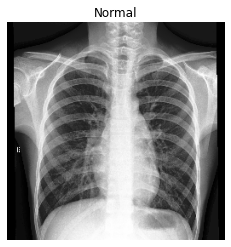

In [8]:
# View a random image from the training dataset
img = view_random_image(target_dir="Covid19-dataset/train/",
                        target_class="Normal")

Image shape: (256, 256, 4)


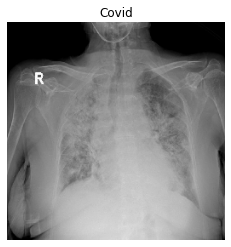

In [9]:
# View a random image from the training dataset
img = view_random_image(target_dir="Covid19-dataset/train/",
                        target_class="Covid")

Image shape: (256, 256, 4)


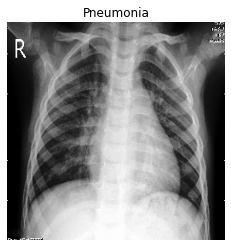

In [10]:
# View a random image from the training dataset
img = view_random_image(target_dir="Covid19-dataset/train/",
                        target_class="Pneumonia")

In [11]:
# View the image shape
img.shape # returns (width, height, colour channels)

(256, 256, 4)

### Prepare data

In [12]:
#Construct an ImageDataGenerator object:
DIRECTORY = "Covid19-dataset/train/"
CLASS_MODE = "categorical"
COLOR_MODE = "grayscale"
TARGET_SIZE = (256,256)


Looking at the image shape more closely, you'll see it's in the form `(Width, Height, Colour Channels)`.



In [13]:
BATCH_SIZE = 32

training_data_generator = ImageDataGenerator(rescale= 1/255,
                                             zoom_range = 0.1,
                                             rotation_range = 25,
                                             height_shift_range = 0.05,
                                             width_shift_range = 0.05)

validation_data_generator = ImageDataGenerator(rescale= 1/255)

training_iterator = training_data_generator.flow_from_directory(directory= "Covid19-dataset/train/",
                                                                target_size=(256, 256),
                                                                color_mode='grayscale',
                                                                class_mode='categorical',
                                                                batch_size=BATCH_SIZE)

validation_iterator = validation_data_generator.flow_from_directory(directory= "Covid19-dataset/test/",
                                                                      target_size=(256, 256),
                                                                      color_mode='grayscale',
                                                                      class_mode='categorical',
                                                                      batch_size=BATCH_SIZE)

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


### Model structure

In [18]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras import losses

In [42]:
def model_structure():
  model = Sequential()
  model.add(Conv2D(10, 3, padding='same', input_shape=(256,256, 1), name = "Conv_1", activation="relu"))
  model.add(Conv2D(10, 3, padding='same', name = "Conv_2", activation="relu"))
  model.add(MaxPool2D(2, name = "maxpool_1"))
  model.add(Conv2D(10, 5, padding='same', name = "Conv_3", activation="relu"))
  model.add(Conv2D(10, 5, padding='same', name = "Conv_4", activation="relu"))
  model.add(MaxPool2D(2, name = "maxpool_2"))
  model.add(Conv2D(15, 7, padding='same', name = "Conv_5", activation="relu"))
  model.add(MaxPool2D(2, name = "maxpool_3"))
  model.add(Flatten())
  model.add(Dense(3, activation="softmax"))

  model.compile(optimizer = Adam(learning_rate=0.0001),
                loss = losses.CategoricalCrossentropy(),
                metrics=["accuracy"])
  model.summary()
  return model

In [43]:
model = model_structure()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv2D)             (None, 256, 256, 10)      100       
                                                                 
 Conv_2 (Conv2D)             (None, 256, 256, 10)      910       
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 128, 128, 10)      0         
                                                                 
 Conv_3 (Conv2D)             (None, 128, 128, 10)      2510      
                                                                 
 Conv_4 (Conv2D)             (None, 128, 128, 10)      2510      
                                                                 
 maxpool_2 (MaxPooling2D)    (None, 64, 64, 10)        0         
                                                                 
 Conv_5 (Conv2D)             (None, 64, 64, 15)       

### Training

In [44]:

history = model.fit(training_iterator,
                    epochs = 100,
                    batch_size = BATCH_SIZE,
                    verbose = 1,
                    validation_data= validation_iterator)

Epoch 1/100
8/8 [==============================] - 3s 306ms/step - loss: 1.0960 - accuracy: 0.3466 - val_loss: 1.0890 - val_accuracy: 0.3939
Epoch 2/100
8/8 [==============================] - 2s 265ms/step - loss: 1.0762 - accuracy: 0.4422 - val_loss: 1.0753 - val_accuracy: 0.3939
Epoch 3/100
8/8 [==============================] - 2s 264ms/step - loss: 1.0552 - accuracy: 0.4422 - val_loss: 1.0591 - val_accuracy: 0.3939
Epoch 4/100
8/8 [==============================] - 2s 265ms/step - loss: 1.0247 - accuracy: 0.4422 - val_loss: 1.0165 - val_accuracy: 0.3939
Epoch 5/100
8/8 [==============================] - 2s 263ms/step - loss: 0.9731 - accuracy: 0.4661 - val_loss: 0.9445 - val_accuracy: 0.6212
Epoch 6/100
8/8 [==============================] - 2s 262ms/step - loss: 0.8888 - accuracy: 0.6255 - val_loss: 0.8396 - val_accuracy: 0.7273
Epoch 7/100
8/8 [==============================] - 2s 262ms/step - loss: 0.7710 - accuracy: 0.7331 - val_loss: 0.7271 - val_accuracy: 0.7121
Epoch 8/100
8

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

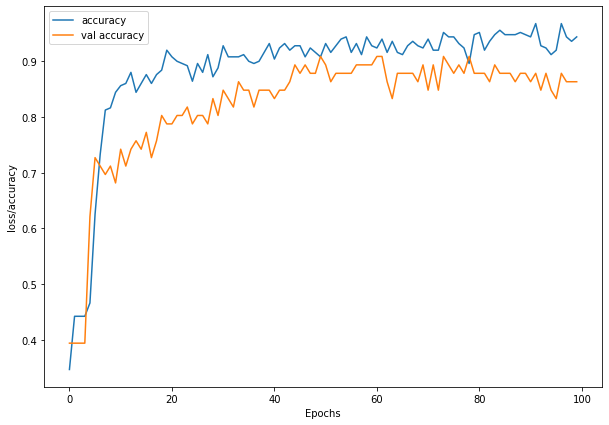

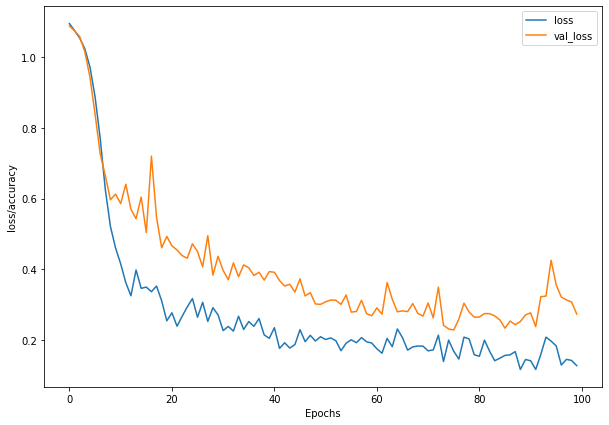

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.plot(history.history['accuracy'], label = "accuracy")
plt.plot(history.history['val_accuracy'], label= "val accuracy")
plt.xlabel("Epochs")
plt.ylabel("loss/accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label = "loss")
plt.plot(history.history['val_loss'], label= "val_loss")
plt.xlabel("Epochs")
plt.ylabel("loss/accuracy")
plt.legend()
plt.show()

In [68]:
model.evaluate(validation_iterator)

3/3 [==============================] - 0s 70ms/step - loss: 0.2725 - accuracy: 0.8636


[0.2724951207637787, 0.8636363744735718]

### fine tunning model


In [51]:
def train_plot_model(model, Epochs):

  history = model.fit(training_iterator,
                      epochs = Epochs,
                      batch_size = BATCH_SIZE,
                      verbose = 0,
                      validation_data= validation_iterator)
  plt.figure(figsize=(10, 7))
  plt.plot(history.history['accuracy'], label = "accuracy")
  plt.plot(history.history['val_accuracy'], label= "val accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("loss/accuracy")
  plt.legend()
  plt.show()

  plt.figure(figsize=(10, 7))
  plt.plot(history.history['loss'], label = "loss")
  plt.plot(history.history['val_loss'], label= "val_loss")
  plt.xlabel("Epochs")
  plt.ylabel("loss/accuracy")
  plt.legend()
  plt.show()
  return history, model

In [55]:
def model_structure_2():
  model = Sequential()
  model.add(Conv2D(10, 3, padding='same', input_shape=(256,256, 1), name = "Conv_1", activation="relu"))
  model.add(Conv2D(10, 3, padding='same', name = "Conv_2", activation="relu"))
  model.add(MaxPool2D(2, name = "maxpool_1"))
  model.add(Conv2D(10, 5, padding='same', name = "Conv_3", activation="relu"))
  model.add(Conv2D(10, 5, padding='same', name = "Conv_4", activation="relu"))
  model.add(MaxPool2D(2, name = "maxpool_2"))
  model.add(Conv2D(20, 7, padding='same', name = "Conv_5", activation="relu"))
  model.add(Conv2D(20, 7, padding='same', name = "Conv_6", activation="relu"))
  model.add(MaxPool2D(2, name = "maxpool_3"))
  model.add(Conv2D(25, 7, padding='same', name = "Conv_7", activation="relu"))
  model.add(MaxPool2D(2, name = "maxpool_4"))
  model.add(Flatten())
  model.add(Dense(3, activation="softmax"))

  model.compile(optimizer = Adam(learning_rate=0.0001),
                loss = losses.CategoricalCrossentropy(),
                metrics=["accuracy"])
  model.summary()
  return model

In [56]:
model_2 = model_structure_2()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv2D)             (None, 256, 256, 10)      100       
                                                                 
 Conv_2 (Conv2D)             (None, 256, 256, 10)      910       
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 128, 128, 10)      0         
                                                                 
 Conv_3 (Conv2D)             (None, 128, 128, 10)      2510      
                                                                 
 Conv_4 (Conv2D)             (None, 128, 128, 10)      2510      
                                                                 
 maxpool_2 (MaxPooling2D)    (None, 64, 64, 10)        0         
                                                                 
 Conv_5 (Conv2D)             (None, 64, 64, 20)      

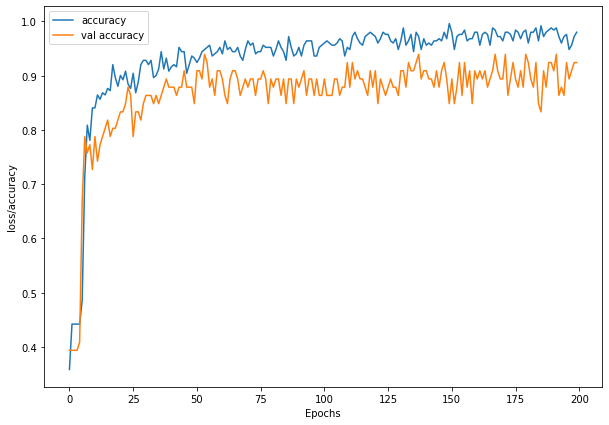

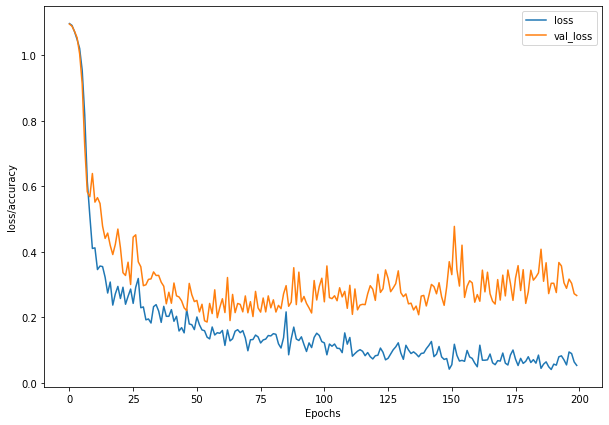

In [57]:
history_2, model_2 = train_plot_model(model_2, 200)

In [67]:
model_2.evaluate(validation_iterator)

3/3 [==============================] - 0s 54ms/step - loss: 0.2663 - accuracy: 0.9242


[0.2662919759750366, 0.9242424368858337]

## Evaluation

In [77]:
def evaluation(model):
  test_steps_per_epoch = numpy.math.ceil(validation_iterator.samples / validation_iterator.batch_size)
  predictions = model.predict(validation_iterator, steps=test_steps_per_epoch)
  test_steps_per_epoch = numpy.math.ceil(validation_iterator.samples / validation_iterator.batch_size)
  predicted_classes = numpy.argmax(predictions, axis=1)
  true_classes = validation_iterator.classes
  class_labels = list(validation_iterator.class_indices.keys())
  report = classification_report(true_classes, predicted_classes, target_names=class_labels)
  print(report)   

  cm=confusion_matrix(true_classes,predicted_classes)
  print(cm)

In [78]:
evaluation(model)

              precision    recall  f1-score   support

       Covid       0.36      0.35      0.35        26
      Normal       0.28      0.25      0.26        20
   Pneumonia       0.22      0.25      0.23        20

    accuracy                           0.29        66
   macro avg       0.29      0.28      0.28        66
weighted avg       0.29      0.29      0.29        66

[[ 9  6 11]
 [ 8  5  7]
 [ 8  7  5]]


In [79]:
evaluation(model_2)

              precision    recall  f1-score   support

       Covid       0.50      0.50      0.50        26
      Normal       0.42      0.40      0.41        20
   Pneumonia       0.33      0.35      0.34        20

    accuracy                           0.42        66
   macro avg       0.42      0.42      0.42        66
weighted avg       0.43      0.42      0.42        66

[[13  6  7]
 [ 5  8  7]
 [ 8  5  7]]
